# Setup

## Basics

In [2]:
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Tensorflow

In [3]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## PyTorch

In [4]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

## More

In [5]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Data Loading

In [6]:
image_data_location = "../input/flickr8k/Images"
caption_data_location = "../input/flickr8k/captions.txt"

In [7]:
df = pd.read_csv(caption_data_location)
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Visualization

In [8]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

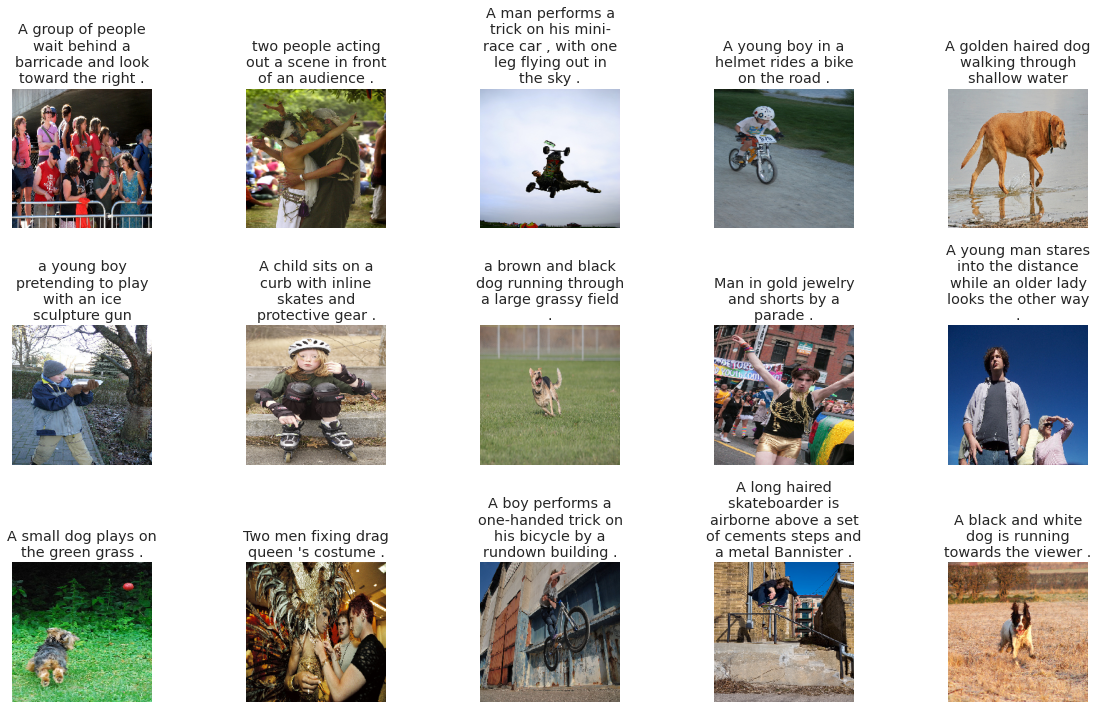

In [9]:
display_images(df.sample(15))

In [10]:
spacy_eng = spacy.load('en_core_web_sm')
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

# Text Preprocessing

* Convert sentences into lowercase
* Remove special characters and numbers present in the text
* Remove extra spaces
* Remove single characters
* Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [11]:
class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self,sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]
                
                

In [12]:
def text_preprocessing(data) :
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    
    return data

## Test

In [13]:
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


In [14]:
df = pd.read_csv(caption_data_location)
print(df["image"][0][::-1])

gpj.e0bc80b396_1028620001


# Dataset class

In [15]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [16]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [17]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Test

In [18]:
# testing the dataset
dataset = CustomDataset(
        root_dir = image_data_location,
        captions_file = caption_data_location,
        transform = transforms
)

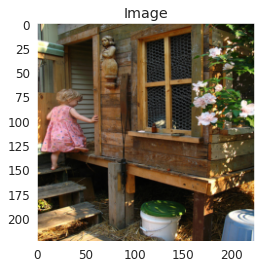

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [19]:
img, caps = dataset[0]
# print(caps)
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [20]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

# DataLoading Config

In [21]:
#writing the dataloader
#setting the constants

BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding

pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

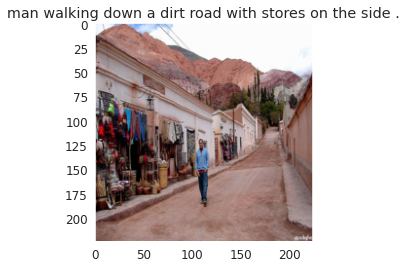

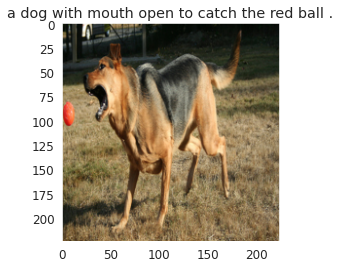

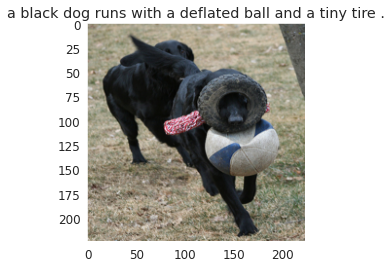

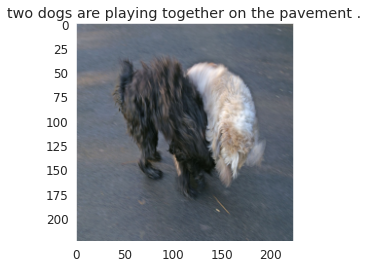

In [22]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

# Modeling

The model consists of two main parts

### Encoder(CNN)
* Which encodes the given image into an array of meaningful features extracted from the images in the dataset

### Decoder(RNN/LSTM) 
* Which takes the encoded feature vector of the image and converts it to the sequence of words, so-called caption

## Encoder(CNN)

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [43]:
class EncoderCNN(nn.Module):
    
    def __init__(self,embed_size, require_grad = False):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(require_grad)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)
        
    def forward(self,images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

## Decoder(RNN/LSTM)

In [44]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self,features, captions):
        embeds = self.embedding(captions[:,:-1])
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)

            predicted_word_idx = output.argmax(dim=1)            
            captions.append(predicted_word_idx.item())

            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
           
        return [vocab.itos[idx] for idx in captions]

## Full Model (Encoder + Decoder) - ImageCaptioning Model

In [45]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3,require_grad = False):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size, require_grad = True)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Training

## Device (GPU(cuda) / CPU)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Config - Hyperparameters

In [47]:
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

## Model definition

In [50]:
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers, require_grad = False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training Loop - Resnet18 Freeze weight

Epoch: 1 loss: 3.51877
features shape - torch.Size([1, 400])
<SOS> a man is running on a <UNK> . <EOS>


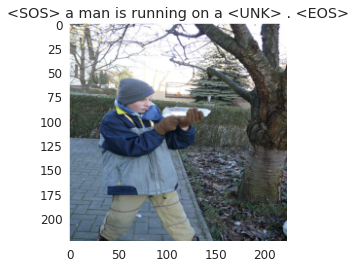

Epoch: 1 loss: 2.93992
features shape - torch.Size([1, 400])
<SOS> a man in a red shirt is standing on a <UNK> . <EOS>


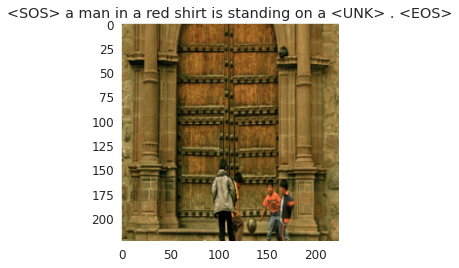

Epoch: 1 loss: 3.10110
features shape - torch.Size([1, 400])
<SOS> a dog is running through the water . <EOS>


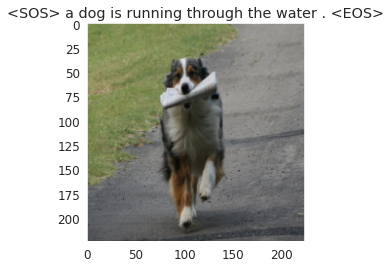

Epoch: 1 loss: 3.29160
features shape - torch.Size([1, 400])
<SOS> a man in a red shirt is standing on a bench . <EOS>


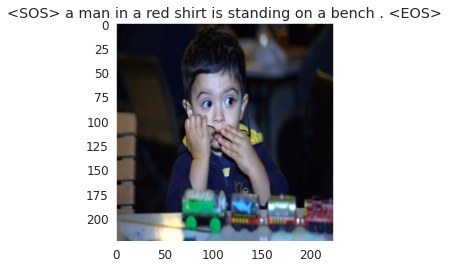

Epoch: 1 loss: 2.67655
features shape - torch.Size([1, 400])
<SOS> a dog is running through the grass . <EOS>


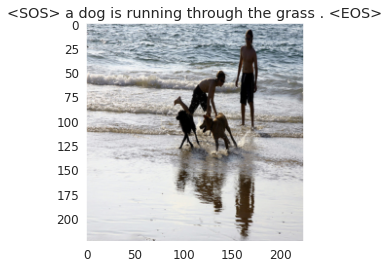

Epoch: 2 loss: 2.49896
features shape - torch.Size([1, 400])
<SOS> a young boy in a red shirt is jumping into the air . <EOS>


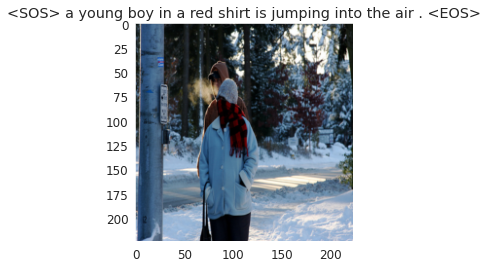

Epoch: 2 loss: 2.47630
features shape - torch.Size([1, 400])
<SOS> a young girl in a red shirt and a black shirt and a black shirt and a black dog


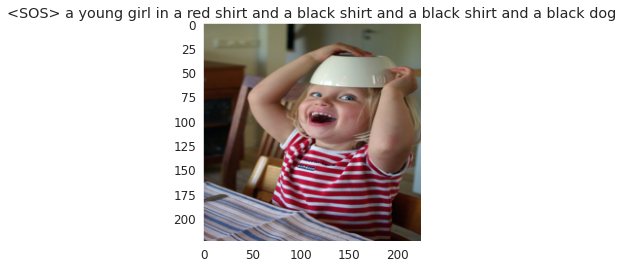

Epoch: 2 loss: 2.26349
features shape - torch.Size([1, 400])
<SOS> a black dog is running through the grass . <EOS>


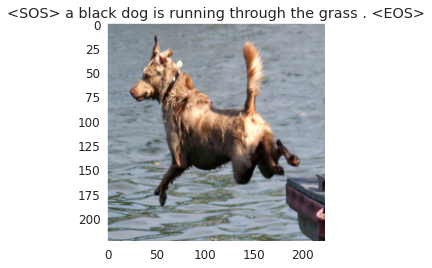

Epoch: 2 loss: 2.44276
features shape - torch.Size([1, 400])
<SOS> a group of people are sitting on a bench in a city . <EOS>


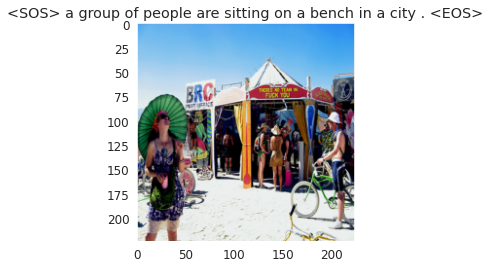

Epoch: 2 loss: 2.51699
features shape - torch.Size([1, 400])
<SOS> a group of people are sitting on a bench . <EOS>


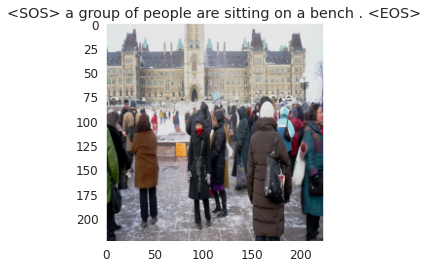

Epoch: 3 loss: 2.50026
features shape - torch.Size([1, 400])
<SOS> a man in a black jacket is standing on a bench with a red bag . <EOS>


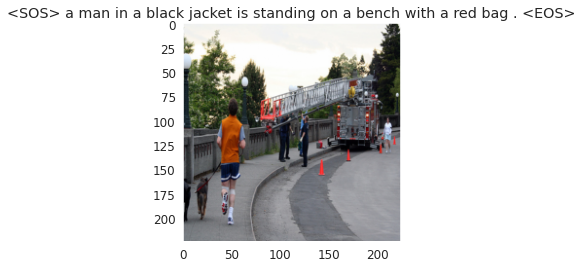

Epoch: 3 loss: 2.50624
features shape - torch.Size([1, 400])
<SOS> a man is riding a bicycle down a hill . <EOS>


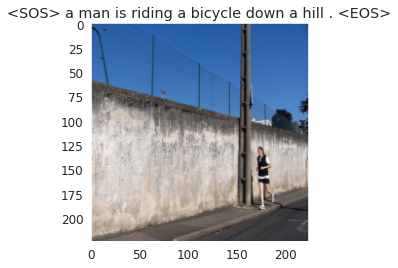

Epoch: 3 loss: 1.96303
features shape - torch.Size([1, 400])
<SOS> a little girl in a pink shirt is jumping into a pool . <EOS>


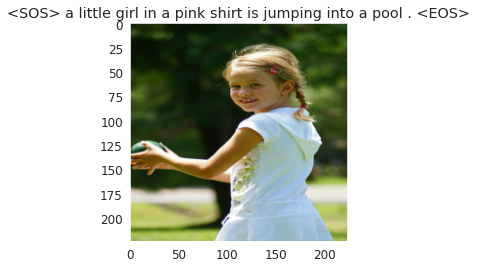

Epoch: 3 loss: 2.53999
features shape - torch.Size([1, 400])
<SOS> a football player in a red uniform is running . <EOS>


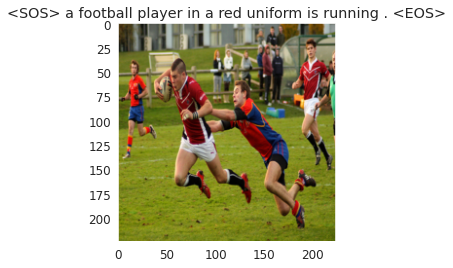

Epoch: 3 loss: 2.43163
features shape - torch.Size([1, 400])
<SOS> a man in a black shirt and a white shirt is standing in front of a crowd . <EOS>


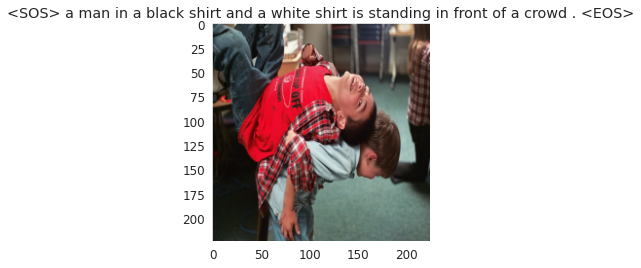

In [ ]:
num_epochs = 20
print_every = 2000

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                print(f"features shape - {features.shape}")
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title=caption)
                
            model.train()

## Training Loop - Resnet18 Unfreeze weight

In [51]:
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers, require_grad = True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1 loss: 1.62648
features shape - torch.Size([1, 400])
<SOS> a group of people are in the water . <EOS>


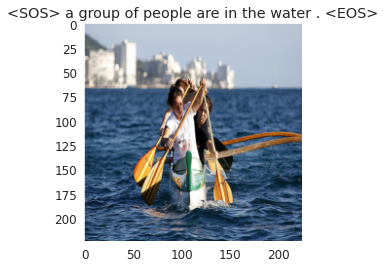

Epoch: 1 loss: 1.56860
features shape - torch.Size([1, 400])
<SOS> a man in a red shirt is standing in front of a crowd of people . <EOS>


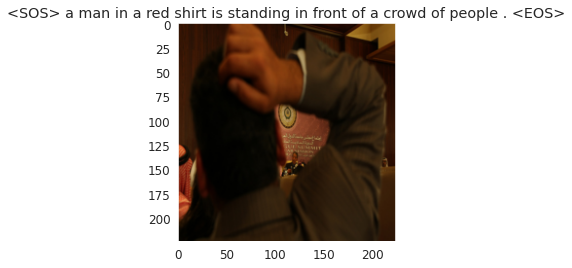

Epoch: 1 loss: 1.58154
features shape - torch.Size([1, 400])
<SOS> a man is surfing on a wave . <EOS>


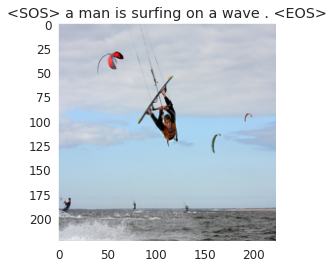

Epoch: 1 loss: 1.50496
features shape - torch.Size([1, 400])
<SOS> a young boy wearing a red shirt is jumping off a swing . <EOS>


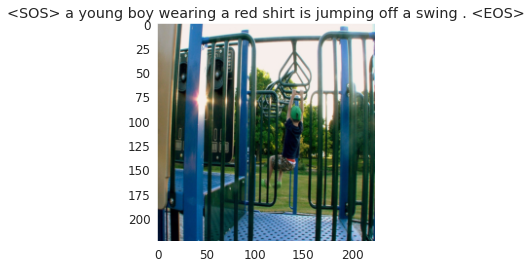

Epoch: 1 loss: 1.76927
features shape - torch.Size([1, 400])
<SOS> a woman in a bikini is standing on a beach with a beach ball . <EOS>


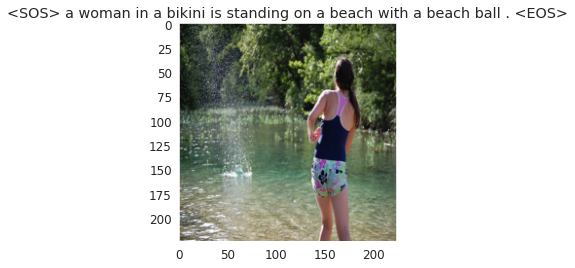

Epoch: 2 loss: 1.03068
features shape - torch.Size([1, 400])
<SOS> two men are playing rugby . <EOS>


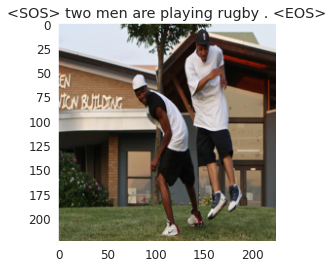

Epoch: 2 loss: 1.43346
features shape - torch.Size([1, 400])
<SOS> four children are playing in a water fountain in a city plaza . <EOS>


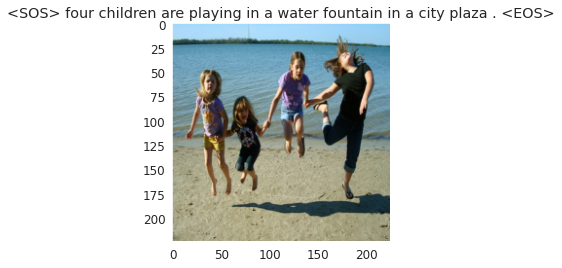

Epoch: 2 loss: 1.44324
features shape - torch.Size([1, 400])
<SOS> a person is climbing a rock while another person is on the back of it . <EOS>


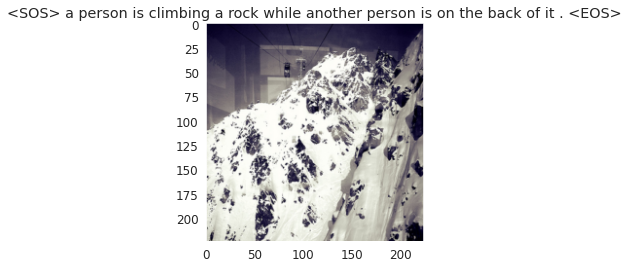

Epoch: 2 loss: 1.49576
features shape - torch.Size([1, 400])
<SOS> a boy jumps into the pool . <EOS>


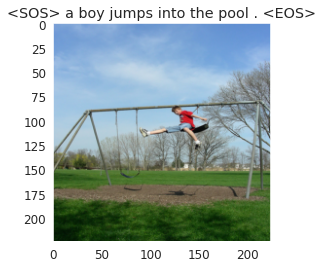

In [ ]:
num_epochs = 20
print_every = 2000

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                print(f"features shape - {features.shape}")
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title=caption)
                
            model.train()

# Final Thoughts

Here we have used a combination of Encoder/Decoder for image captioning. The idea was to use CNN structure which we used the pretrained model ***Resnet18***, both with and without training its layers. 
The second phase consists of a Decoder which is the ***LSTM*** model in our structure. finally with the combination of these two we have our final model. 

## Comparison 

For the comparison between using the freezed pretrained weights during the training of our model or unfreezing the whole Resnet18 model, it is clear that the model performes significantly better while the CNN Encoder is also learning, however due to the fact that Resnset18 and most of pretrained models are considered very deep, the training-time and the computational power has grown exponentially.

So in order to choose whether to freeze or unfreeze the encoderCNN (in this case Resnet18) We have to take both the ***performance*** and ***Computational power*** into consideration.